In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
X_train.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0


In [4]:
# Use Logistic Regression as Benchmark 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.4834355828220859

The Logistic Regression Score provides us with a reference.  We will use boosting to improve this score.

In [5]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0469541199938622
Percent Type II errors: 0.17784256559766765

Test set accuracy:
Percent Type I errors: 0.10429447852760736
Percent Type II errors: 0.15521472392638036


The Gradient Boosting Classifer increases the baseline Logistic Regression score from 48% to 74%.  

In [6]:
clf.score(X_test, y_test)

0.7404907975460123

In [7]:
#Create Confusion Matrix  
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[831, 170],
       [253, 376]])

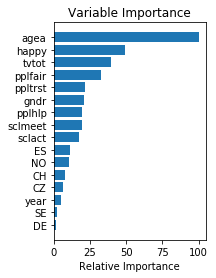

In [8]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 10
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Feature Engineeing

In [9]:
#Create new feature to rescale the agea feature in comparison to other features.
X['agea_normalized'] = X.agea/10

#Create new feature to rescale gender feature
X['gndr_2'] = X.gndr - 1

#Combine 'ppltrst' 'pplfair' 'pplhlp' features
X['trst_fair_hlp'] = X['ppltrst'] * X['pplfair'] *X['pplhlp']

X_2 = X.drop(['agea','CZ','CH','DE','ES','NO','SE','ppltrst','pplfair','pplhlp'], axis=1)
X_2.head()

,year,tvtot,happy,sclmeet,sclact,gndr,agea_normalized,gndr_2,trst_fair_hlp
0,6,3.0,8.0,5.0,4.0,2.0,6.0,1.0,150.0
1,6,6.0,9.0,3.0,2.0,2.0,5.9,1.0,175.0
2,6,1.0,7.0,6.0,3.0,1.0,2.4,0.0,512.0
3,6,4.0,10.0,6.0,2.0,2.0,6.4,1.0,252.0
4,6,5.0,8.0,7.0,2.0,2.0,5.5,1.0,210.0


In [10]:
#Check dataframe for correlations
X_2['partner'] = df.partner
X_2.corr()

,year,tvtot,happy,sclmeet,sclact,gndr,agea_normalized,gndr_2,trst_fair_hlp,partner
year,1.000000,-0.031596,-0.013378,-0.028502,0.012150,0.001355,-0.003520,0.001355,-0.014315,0.018689
tvtot,-0.031596,1.000000,-0.118598,-0.078864,-0.092375,0.017922,0.257674,0.017922,-0.117604,-0.028816
happy,-0.013378,-0.118598,1.000000,0.182944,0.192030,-0.022413,-0.042970,-0.022413,0.258254,-0.145061
sclmeet,-0.028502,-0.078864,0.182944,1.000000,0.283319,0.009533,-0.194443,0.009533,0.117601,0.162970
sclact,0.012150,-0.092375,0.192030,0.283319,1.000000,-0.031648,-0.059442,-0.031648,0.137078,0.011405
gndr,0.001355,0.017922,-0.022413,0.009533,-0.031648,1.000000,0.020598,1.000000,0.024903,0.033984
agea_normalized,-0.003520,0.257674,-0.042970,-0.194443,-0.059442,0.020598,1.000000,0.020598,0.034437,-0.256670
gndr_2,0.001355,0.017922,-0.022413,0.009533,-0.031648,1.000000,0.020598,1.000000,0.024903,0.033984
trst_fair_hlp,-0.014315,-0.117604,0.258254,0.117601,0.137078,0.024903,0.034437,0.024903,1.000000,-0.045833
partner,0.018689,-0.028816,-0.145061,0.162970,0.011405,0.033984,-0.256670,0.033984,-0.045833,1.000000


In [16]:
#Remove partner feature from X
X_3 = X_2.drop('partner',axis=1)
X_3.head()

,year,tvtot,happy,sclmeet,sclact,gndr,agea_normalized,gndr_2,trst_fair_hlp
0,6,3.0,8.0,5.0,4.0,2.0,6.0,1.0,150.0
1,6,6.0,9.0,3.0,2.0,2.0,5.9,1.0,175.0
2,6,1.0,7.0,6.0,3.0,1.0,2.4,0.0,512.0
3,6,4.0,10.0,6.0,2.0,2.0,6.4,1.0,252.0
4,6,5.0,8.0,7.0,2.0,2.0,5.5,1.0,210.0


In [17]:
#Prepare X train and X test
X_train, X_test, y_train, y_test = train_test_split(X_3, y)

In [22]:
#Define various classifers for voting
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=2000)
gb = GradientBoostingClassifier()
gnb = GaussianNB()
brb = BernoulliNB()
knn = KNeighborsClassifier(n_neighbors=7)
dtc = DecisionTreeClassifier(max_depth=4)

In [23]:
#Use Voting Classifer 
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gb',gb) ,('knn',knn),('dtc', dtc)], voting='hard')
vc.fit(X_train, y_train)
vc.score(X_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7555228276877761

In [24]:
#Validate model with 10 folds
from sklearn.model_selection import cross_val_score
cross_val_score(vc, X_test, y_test, cv=10)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

array([0.76097561, 0.75      , 0.75490196, 0.79901961, 0.78921569,
       0.75      , 0.70935961, 0.75862069, 0.7635468 , 0.72906404])

After Feature Engineering and utilzing the Voting Classifer I was able to increase the 74% to 74.5%.  Overall, it appears that accuracy threshold is close to 75/76%.  There is an opportunity to maybe collect some new data initally to improve the accuracy of the model.